# Seed Analysis Tutorial

In [50]:
#Import libraries

%matplotlib notebook
import os
import argparse
import matplotlib
import cv2
import numpy as np

from plantcv import plantcv as pcv

In [51]:
# Input image into self.image (include file path if image is not in 
# the same folder as jupyter notebook)

# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

class options:
    def __init__(self):        
        self.image = "cq0205.001-2.jpg" 
        self.debug = "plot"
        self.writeimg = False
        self.result = "seed_analysis_results"
        self.outdir = ""
        
# Get options
args = options()

# FILL IN
pcv.params.debug_outdir = args.outdir

# Set debug to the global parameter
pcv.params.debug = args.debug

<IPython.core.display.Javascript object>


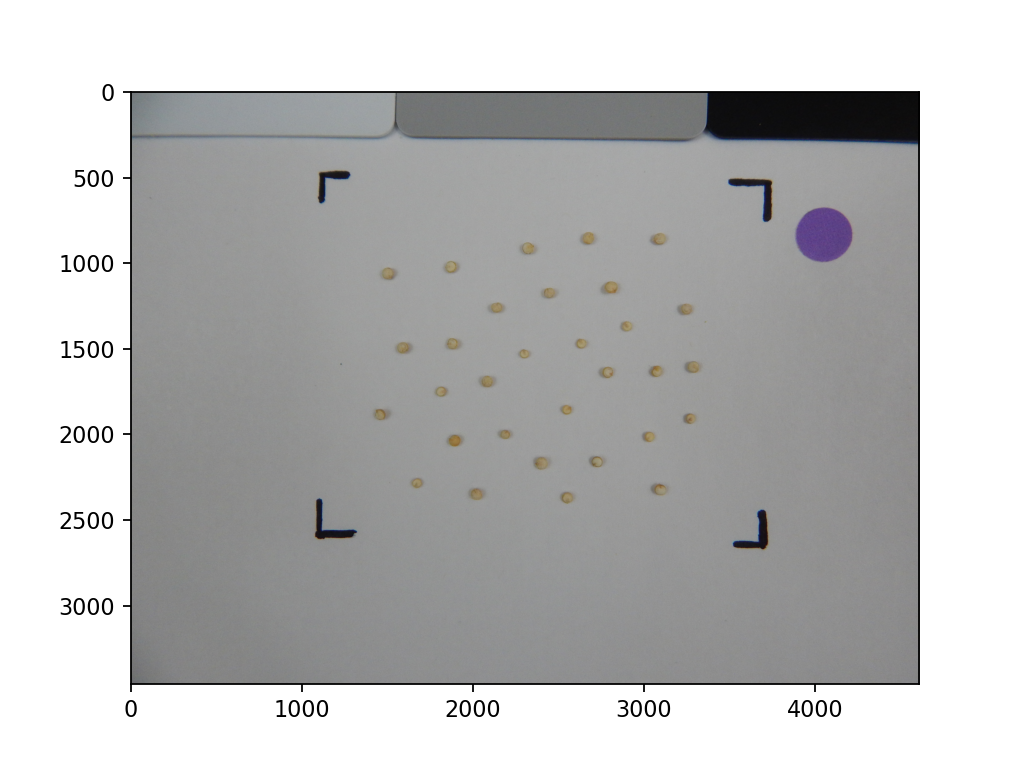

In [52]:
# Read image (sometimes you need to run this line twice to see the image) 

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'

img, path, filename = pcv.readimage(filename=args.image)

In [53]:
#Increase text size and thickness to make labels clearer (size may need to
#be altered based on original image size)

pcv.params.text_size = 10
pcv.params.text_thickness = 20

<IPython.core.display.Javascript object>


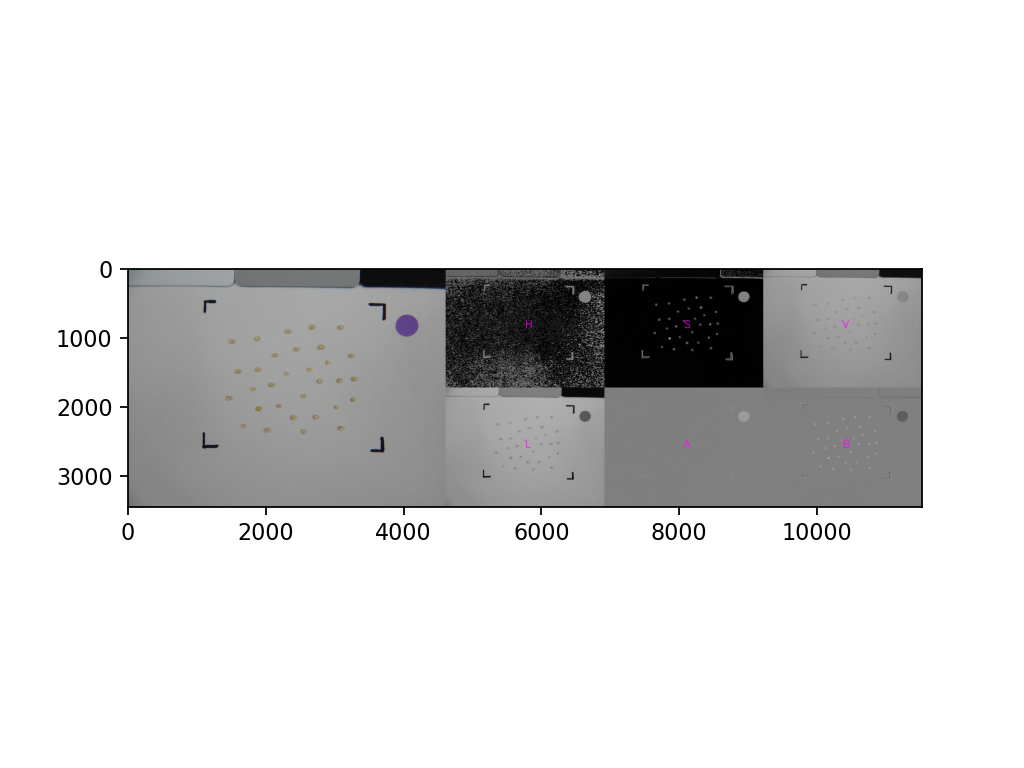

In [54]:
#Visualize colorspaces to select the channel which best isolated seeds
#from the background

# Inputs:
#   rbg_img - original image
colorspace_img = pcv.visualize.colorspaces(rgb_img=img)

<IPython.core.display.Javascript object>


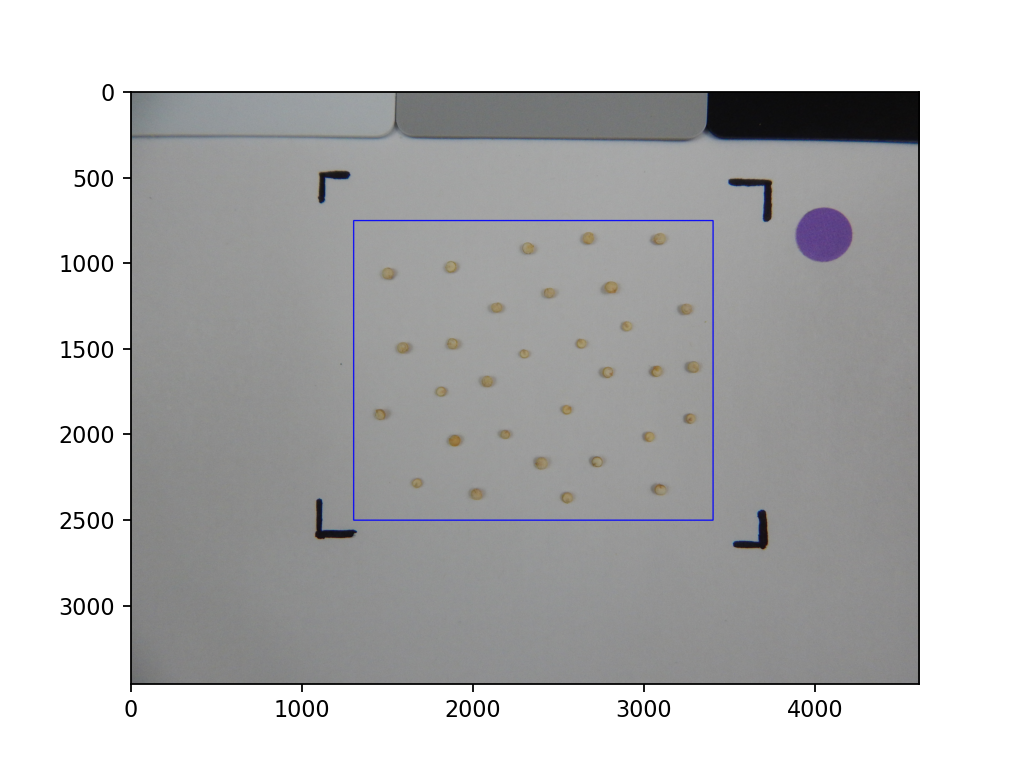

In [55]:
# Crop image

# Inputs:
#   x - top left x-coordinate
#   y - top left y-coordinate
#   h - height of final cropped image
#   w - width of final cropped image
img = pcv.crop(img=img, x=1300, y=750, h=1750, w=2100)

<IPython.core.display.Javascript object>


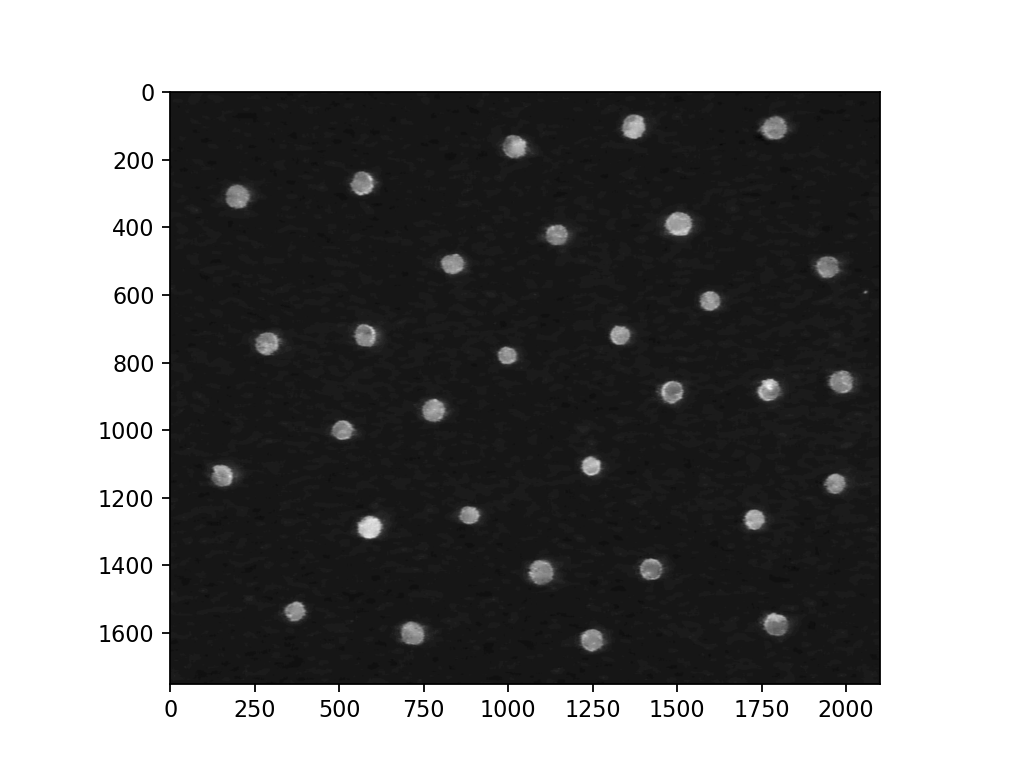

In [56]:
#Select a colorspace that best isolated seeds from background

# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('l', 'a', or 'b')
b_img = pcv.rgb2gray_lab(rgb_img=img, channel='b')

<IPython.core.display.Javascript object>


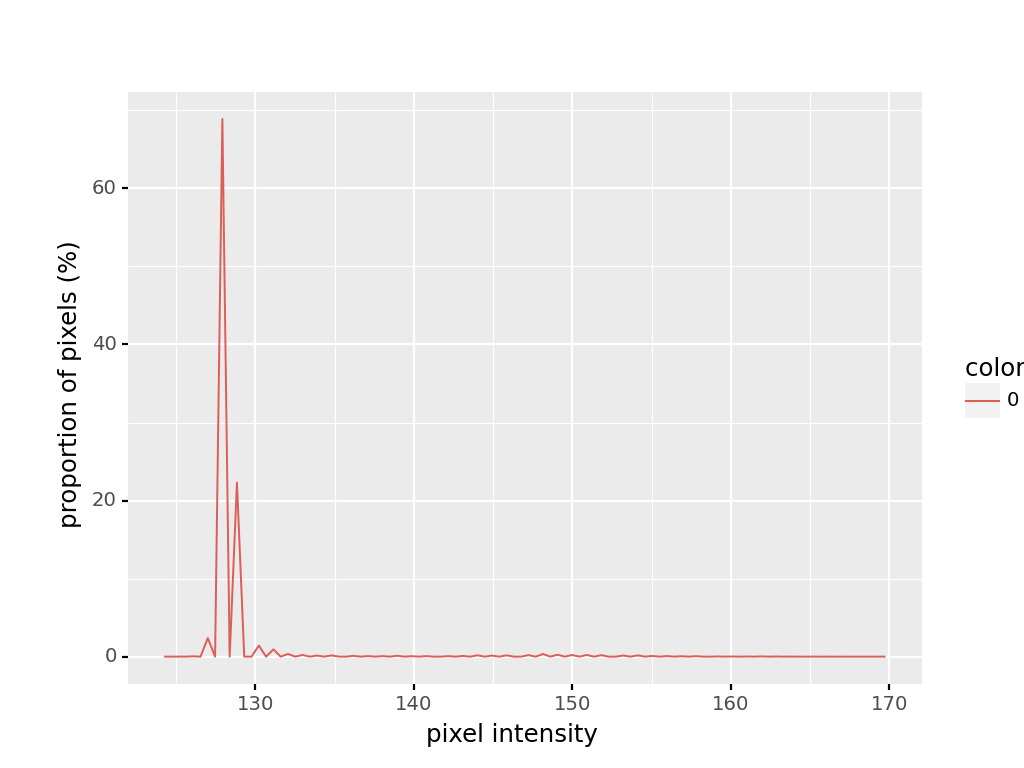

In [57]:
# Visualize histogram of colors within image

# Inputs:
#   img - gray image in selected colorspace
#   mask - None (default), or mask
#   bins - 100 (default) or number of desired number of evenly spaced bins
#   lower-bound - None (default) or minimum value on x-axis
#   upper-bound - None (default) or maximum value on x-axis
#   title - None (default) or custom plot title
#   hist_data - False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=b_img)

<IPython.core.display.Javascript object>


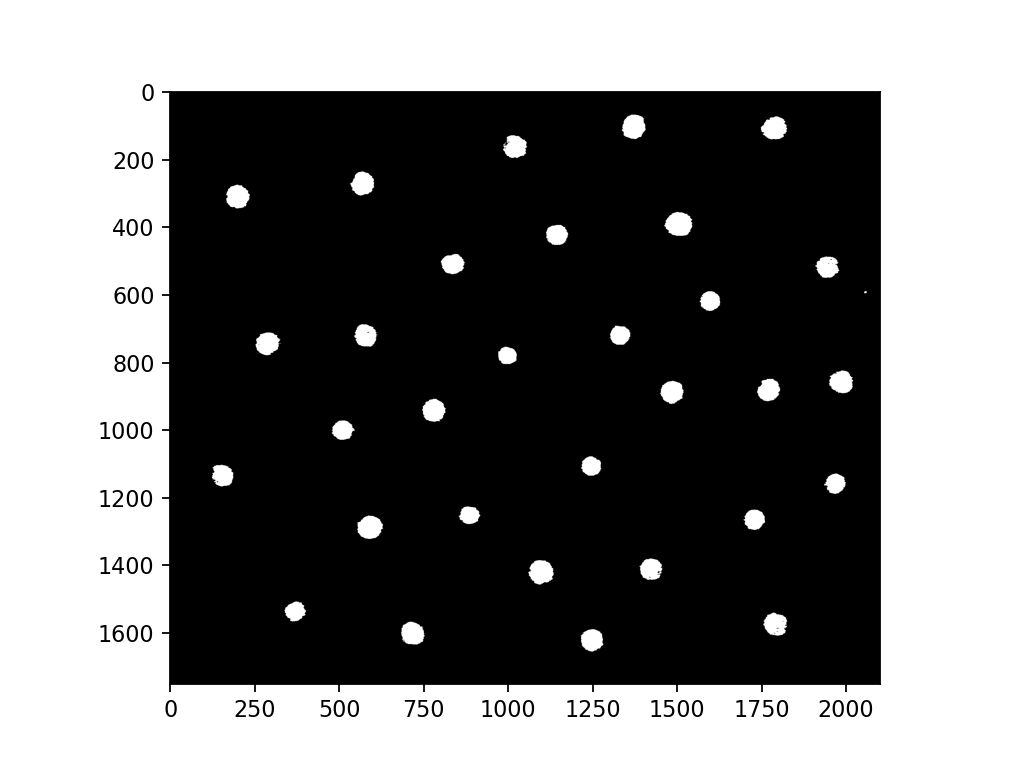

In [58]:
# Create binary mask for image

# Inputs:
#   gray_img - black and white image created from selected colorspace
#   threshold - cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value - maximum pixel value
#   object_type - 'dark' or 'light' depending on if seeds are darker or lighter than background
b_thresh = pcv.threshold.binary(gray_img=b_img, threshold=140, max_value=255, object_type='light')
#                                                          ^                                 ^
#                                                          |                                 |
#                                                  change this value                  change this value


<IPython.core.display.Javascript object>


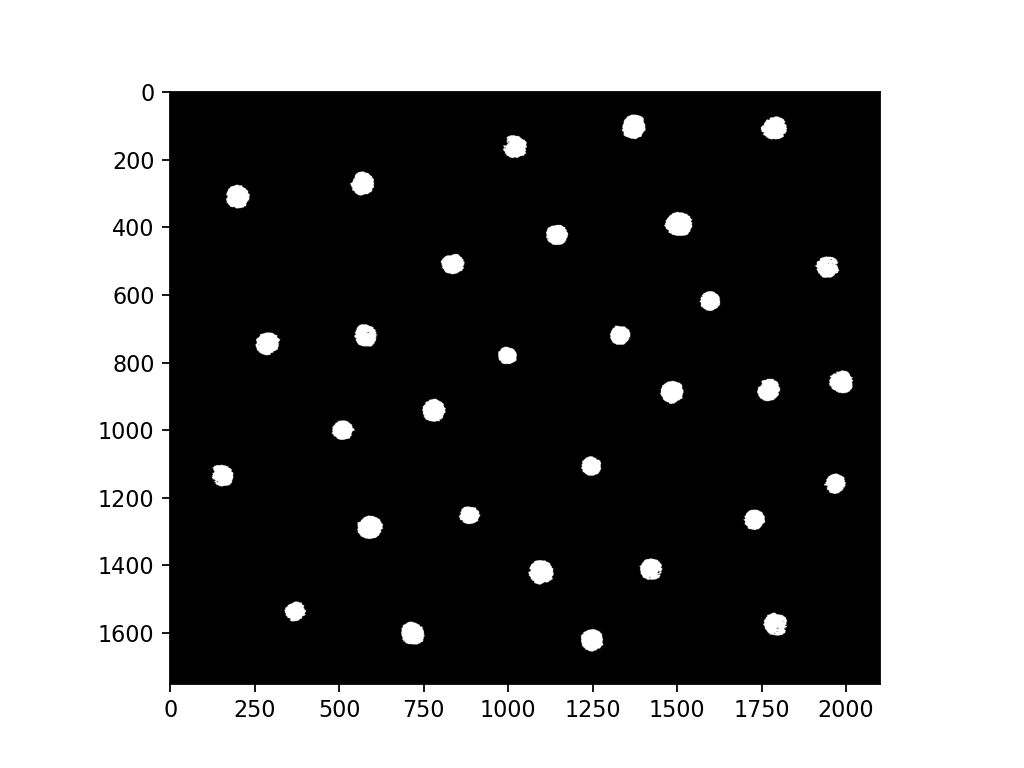

In [59]:
# Fill in areas smaller than a defined theshold size, in order to reduce static noise 
# around desired objects

# Inputs:
#   bin_img - binary mask image
#   size - maximum size for objects that should be filled in as background (non-plant) pixels
b_fill = pcv.fill(bin_img=b_thresh, size=300)
#                                         ^
#                                         |
#                                 change this value

In [60]:
# Define simple contours to identify each seed (note: the output from this CANNOT be used when doing the shape &
# color analysis)

# Inputs:
#   mask - binary mask with extra noise filled in
#   cv2.RETR_EXTERNAL - cv2 input to disregard contours within contours
#   cv2.CHAIN_APPROX_SIMPLE
objects = cv2.findContours(b_fill, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [61]:
# Find number of seeds

# Inputs:
#    contours - list of contours
number_seeds = len(objects[1])

<IPython.core.display.Javascript object>


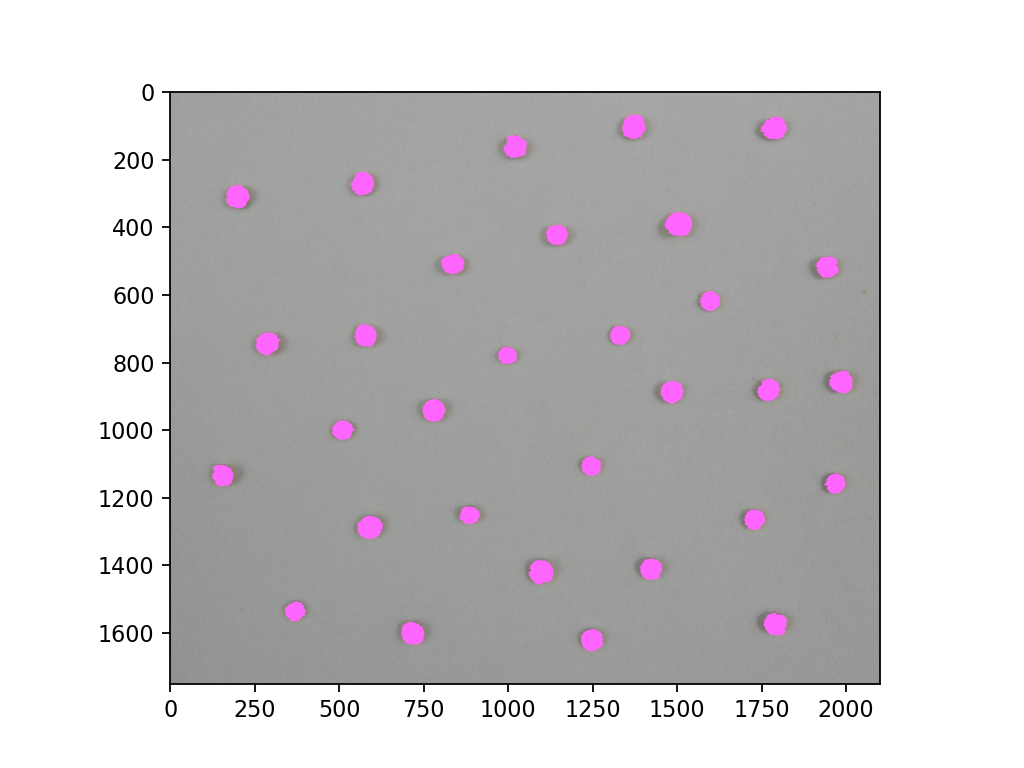

In [62]:
# Find all objects (including objects within objects) and the hierarchy (note: the resulting object and object hierarchy
# from this step is used when doing shape & color analysis)

# Inputs:
#   img - rgb image
#   mask - binary mask
objects2, obj_hierarchy = pcv.find_objects(img=img, mask=b_fill)

In [67]:
# Turn off plot debugging
pcv.params.debug = None

# Create a copy of the RGB image for shape analysis annotations
shape_img = np.copy(img)

# Interate through all objects in objects2 and do a shape and color analysis
for i in range(0, len(objects2)):
    # Check to see if the object has an offshoot in the hierarchy
    if obj_hierarchy[0][i][3] == -1:
        # Create an object and a mask for one object
        #
        # Inputs:
        #   img - rgb image
        #   contours - list entry i in objects2
        #   hierarchy - np.array of obj_hierarchy[0][1]
        seed, seed_mask = pcv.object_composition(img=img, contours=[objects2[i]], hierarchy=np.array([[obj_hierarchy[0][i]]]))
        
        # Analyze shape of each seed
        #
        # Inputs:
        #   img - rgb image
        #   obj - seed
        #   mask - mask created of single seed
        #   label - label for each seed in image
        shape_img = pcv.analyze_object(img=shape_img, obj=seed, mask=seed_mask, label=f"seed{i}")
        
        # Analyze color of each seed
        #
        # Inputs:
        #   img - rgb image
        #   obj - seed
        #   hist_plot_type - 'all', or None for no histogram plot
        #   label - 'default'      
        color_img = pcv.analyze_color(rgb_img=img, mask=b_fill, hist_plot_type=None, label="default")
            

<IPython.core.display.Javascript object>


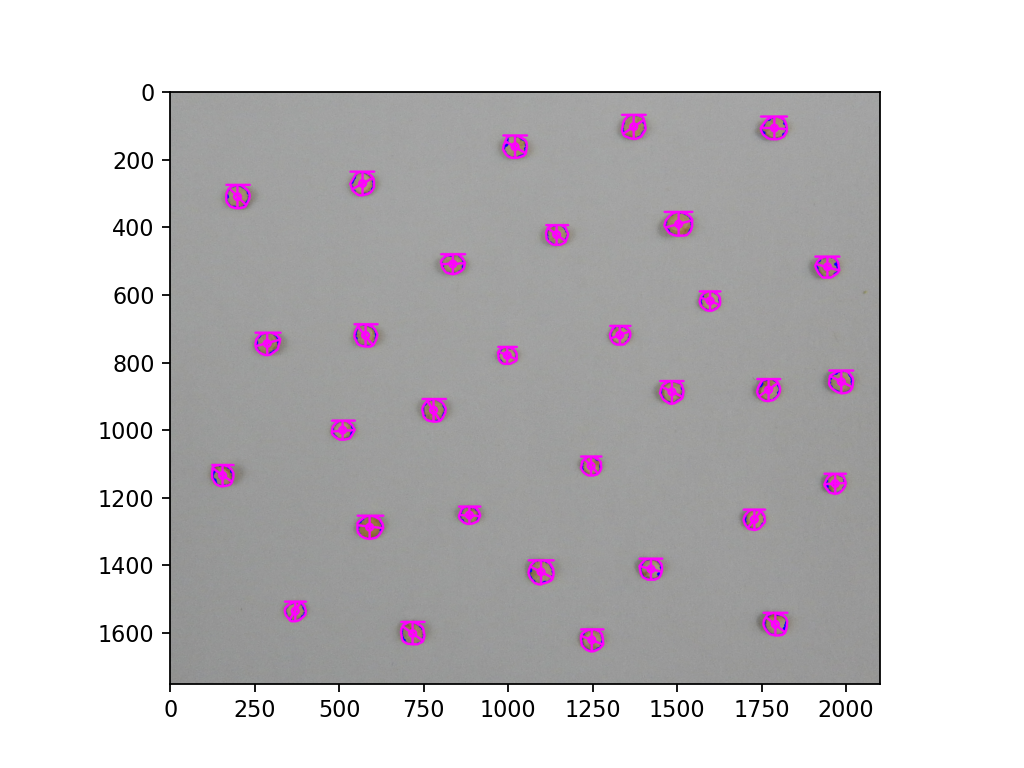

In [64]:
# Visualize shape analysis

# Inputs:
#   img = image for shape analysis
pcv.plot_image(img=shape_img)

<IPython.core.display.Javascript object>


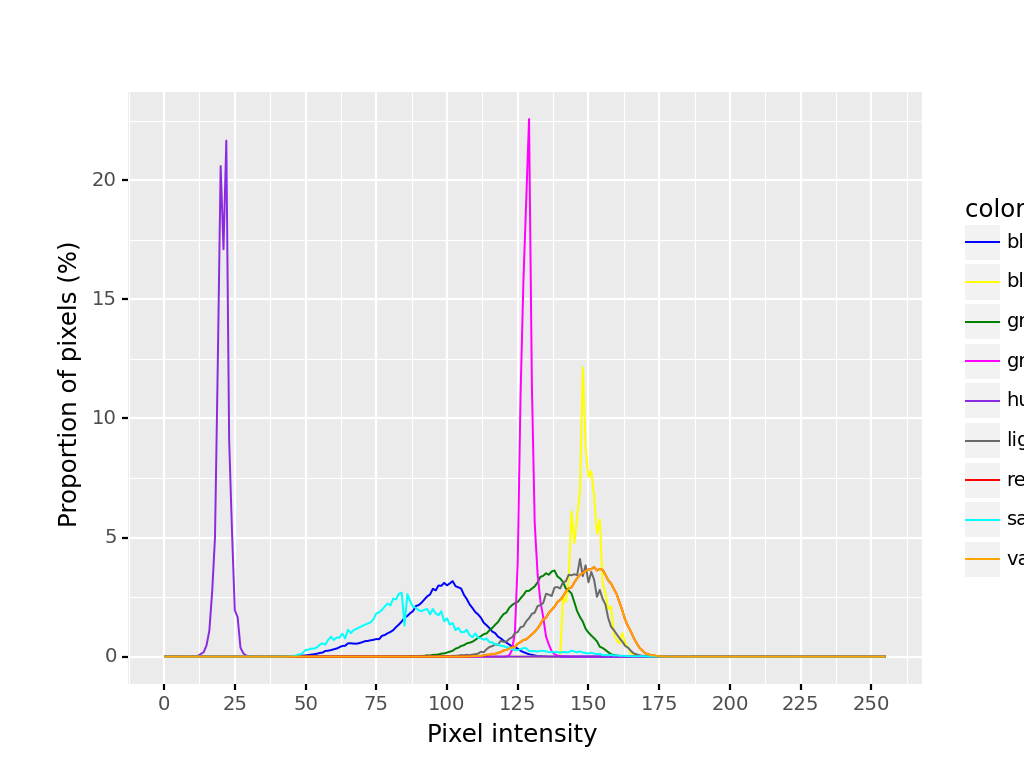

In [65]:
# Visualize color analysis

# Inputs:
#   img = image for color analysis
pcv.plot_image(img=color_img)

In [66]:
pcv.outputs.save_results(filename=args.result)